# BME303 Kaggle Nuclei Segmentation
**by Marisa Ballard, Armaan Chokshi, Sneha Pallipuram, Kevin Wang, Kevin Wu**


# Introduction

<img src=https://www.uaz.edu.mx/histo/Webpatutah/jpeg5/CV022.jpg width="300">

 Estimation= Not very accurate

 Counting by Volume= Cell deberis= Not very accurate

 ### Problem Statement
 Design a method to count cells by cell nuclei and make it as accurately as possible.

In [1]:
import numpy as np  #we use numpy for array manipulations
from PIL import Image    # we use Image to create, open, and save images
import matplotlib.pyplot as plt #used to display images
from skimage.feature import blob_log    #imports the Laplacian of Gaussian function for use in counting number of nuclei
import glob #used to consider things in an image as objects
from skimage.io import imread   #used to read an image
import cv2 # library for image processing and machine learning 

In [2]:
# convert color image to grayscale
def rgb2gray(name):
    file_name = name
    original = cv2.imread(file_name) # "original" as input file
    gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY) # convert to grayscale

    plt.imshow(gray, cmap='Greys_r') # generate 1 channel color map from array of pixel values and display
    plt.show()

    gray_img = Image.fromarray(gray) # converts numpy array into PIL image
    gray_img.save('gray_' + file_name, cmap='Greys_r') # save new grayscale image in 1 color channel

    return 'gray_' + file_name

#def main():
#    file_name = input("Enter file name")   
#    rgb2gray(file_name + '.jpg')

#main()

In [3]:
#defines function for resizing an image while preserving aspect ratio
def resize_PAR(name, scale_percent = 80): # defaulting scale percentage at 80%
    file_name = name + '.jpg'
    original = cv2.imread(file_name)
    plt.imshow(original)   # display original image and later resized to show change
    plt.show()  
    
    print('Original Dimensions: ', original.shape)
    length = int(original.shape[0] * scale_percent / 100) # scale length by scale percentage
    width = int(original.shape[1] * scale_percent / 100) # scale width by scale percentage
    dimensions = (length, width) # store length and width as tuple
    
    if scale_percent < 100: # if shrinking image, uses INTER_AREA interpolation
        resized = cv2.resize(original, dimensions, interpolation = cv2.INTER_AREA) 
    else: # if enlarging image, uses INTER_LINEAR interpolation 
        resized = cv2.resize(original, dimensions, interpolation = cv2.INTER_LINEAR)
        
    print('Resized Dimensions: ', resized.shape)

    resized_img = Image.fromarray(resized) #convert numpy array to PIL image

    plt.imshow(resized_img) # display resized image
    plt.show()

    resized_file_name = 'resize_PAR_' + file_name       # standardize resized image file names
    resized_img.save(resized_file_name, cmap='Greys_r') # save new resized image as grayscale for future ML use

    return resized_file_name


#def main():
#    file_name = input("Enter file name")
#    test = resize_PAR(file_name)

#main()

In [4]:
#defines function for resizing the image to any input size, defaulting at 512x512
def resize(name, new_length=512, new_width=512):
    file_name = name + '.jpg'
    original = cv2.imread(file_name)
    print('Original Dimensions: ', original.shape) # output dimensions of old and later new image to show change

    dimensions = (new_length, new_width) # new desired dimensions stored as tuple

    plt.imshow(original)                 # display original and resized to illustrate change
    plt.show()

    resized = cv2.resize(original, dimensions, interpolation=cv2.INTER_AREA) # INTER_AREA interpolation to resize to desired

    print('Resized Dimenesions: ', resized.shape) 

    #displays the resized image
    plt.imshow(resized)
    plt.show()

    resized_file_name = 'resize_' + str(new_length) + 'x' + str(new_width) + "_" + file_name # standardize saved file name
    resized_img = Image.fromarray(resized)  # convert numpy array to PIL image
    resized_img.save(resized_file_name, cmap='Greys_r') # save file as grayscale for future use

    return resized_file_name    #returns the new file name

#def main():
#    file_name = input("Enter file name")
#    test = resize(file_name, 750, 750)

#main()

Enter file nameinvert


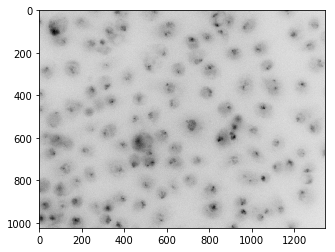

In [11]:
# invert colors, primarily used for grayscale images with light nuclei and dark background
def invert(name):
    file_name = name + '.jpg'
    original = cv2.imread(file_name)
    inverted = cv2.bitwise_not(original) # built in cv2 function for inverting colors
    
    plt.imshow(inverted)
    
    plt.show()
    
    
def main(): 
    file_name = input("Enter file name")  # test file name: "invert.jpg"
    invert(file_name)

main()

<img src=https://blogs.mathworks.com/images/steve/60/nuclei.png width="500">

Enter file nameinvert


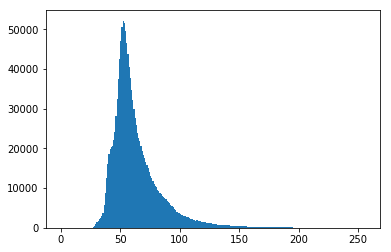

In [12]:
# generate histogram of pixel values
def generate_hist(name):
    file_name = name + '.jpg'
    img = cv2.imread(file_name, 0) # flattens the image into 1 color channel without regard to initial amount of channels 
    plt.hist(img.ravel(),256,[0,256]); plt.show() # built in plt function for generating histogram
    
                     
def main():
    file_name = input("Enter file name")
    generate_hist(file_name)

main()


In [7]:
#defines a function for finding original height of the image
def find_orig_height(name):
    file_name = name + '.jpg'   #sets file name
    original = cv2.imread(file_name)    #reads the image
    orig_height, orig_width, channels = original.shape  #sets variables equal to the dimensions of the image
    return orig_height  #returns the original image height


#defines a function for finding the new height of the image
def find_new_height(name):
    #we will have the input be the resized image
    resized = cv2.imread(name)  #reads the resized image
    new_height, new_width, channels = resized.shape #sets variables equal to the dimensions of the image
    return new_height   #returns the height of the resized image

In [8]:
#defines function for counting the nuclei in an image that is in grayscale
def count_nuclei(name, new_height, original_height):
    img = Image.open(name) #defines img as the nuclei image we want to examine

    pix_val = list(img.getdata())   #puts the values of each pixel from the nuclei image into a list
                                    #each pixel value is a list

    pix_val_size = len(pix_val) #sets pix_val_size equal to the length of the data set of 1-channel pixel values

    #iterates for each row (pixel)
    for i in range(pix_val_size):
        j = 0   #j must be 0 for proper use in the below if statement

        #if the pixel is not intense enough, sets the pixel to (0, 0, 0), or the color black
        if pix_val[i] < 115:
            pix_val[i] = 0

        #otherwise, the pixel is set to 255, or the color white
        else:
            pix_val[i] = 255

    true_img = Image.new(img.mode, img.size)    #creates a new, blank image with same dimensions as the original one
    true_img.putdata(pix_val)   #fills the blank image with the new pixel values

    #displays the new images
    plt.imshow(true_img, cmap='Greys_r')
    plt.show()

    true_img.save('B&W.jpg')    #saves the new image as "B&W.jpg"



    ex_file = glob.glob('B&W.jpg')[0]   #sets ex_file to be the "B&W.jpg", which was created above, with objects in it (the nuclei)
    count_img = imread(ex_file, as_gray=True)   #converts the image to grayscale

    #calls the imported blob_log function, which uses surface formulas to find the number of objects in an image
    blobs_log = blob_log(count_img, min_sigma=14*new_height/original_height, max_sigma = 45*new_height/(2*original_height), num_sigma= 10*new_height/original_height, threshold=.1)
        #min_sigma is the minimum size of an object we want to actually count as an object
        #max_sigma is the maximum size of an object we want to actually count as an object
        #num_sigma is the number of intermediate values of standard deviations to consider between min and max sigma
        #threshold is the lowest pixel intensity we want to consider when counting something as an object

    numrows=len(blobs_log)  # the length of blobs_log is the number of nuclei

    return print("Number of nuclei: ", numrows)    #prints the number of nuclei in the image

In [9]:
#defines function for counting nuclei in an image that is not in grayscale
def count_nuclei_bw(name, original_height, new_height):
    img = Image.open(name)

    pix_val = list(img.getdata())

    array = np.asarray(pix_val)

    row = np.size(array, 0)

    for i in range(row):
        j = 0  # j must be 0 for proper use in the below if statement

        # if the pixel is not intense enough, sets the pixel to (0, 0, 0), or the color black
        if array[i, j] < 20 and array[i, j + 1] < 20 and array[i, j + 2] < 20:
            array[i, j] = 0
            array[i, j + 1] = 0
            array[i, j + 2] = 0

        # otherwise, the pixel is set to (255, 0, 0), or the color red
        else:
            array[i, j] = 255
            array[i, j + 1] = 0
            array[i, j + 2] = 0

    im_list = tuple(map(tuple, array))  #converts the array of new pixel values back into a tuple so that the tuple can be used to generate a new image
    true_img = Image.new(img.mode, img.size)
    true_img.putdata(im_list)

    # displays the new images, with each nuclei highlighted red
    plt.imshow(true_img)
    plt.show()

    true_img.save('red.jpg')  # saves the new image as "red.jpg"

    ex_file = glob.glob('red.jpg')[0]
    count_img = imread(ex_file, as_gray=True)

    blobs_log = blob_log(count_img, min_sigma=14*new_height/original_height, max_sigma=45*new_height/(2*original_height), num_sigma=10*new_height/original_height, threshold=.1)

    numrows = len(blobs_log)

    print("Number of nuclei: ", numrows)

Enter file name:thumbnail_nuclei


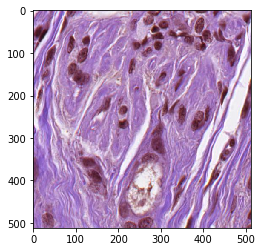

Original Dimensions:  (512, 512, 3)
Resized Dimensions:  (768, 768, 3)


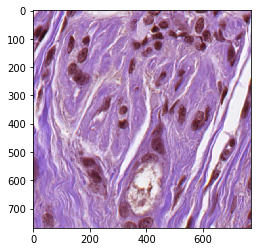

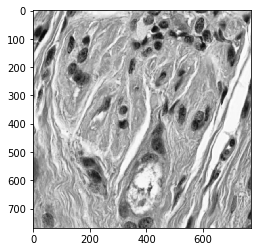

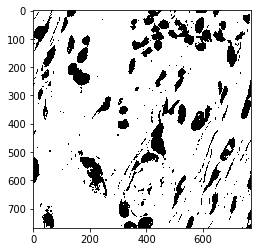

Number of nuclei:  70


In [10]:
#the main function, which calls the above function to resize the image, convert it to grayscale if necessary,
# and count the nuclei in it
def main():
    file_name = input("Enter file name:")   #asks user for the file name
    #rgb2gray(file_name)
    resized_dim = resize_PAR(file_name, 150)    #calls resize_PAR function to obtain a resized image
    #resized_dim = resize(file_name)            #calls resize function to obtain a resized image

    orig_height = find_orig_height(file_name)   # calls find_orig_height function to obtain the image's original height
    new_height = find_new_height((resized_dim)) #calls find_new_height function to obtain the resized image's height
    
    # color input
    count_nuclei(rgb2gray(resized_dim), new_height, orig_height)    #calls count_nuclei function to find the number of nuclei in the resized, grayscale image
    # b&w input
    #count_nuclei_bw(resized_dim, new_height, orig_height)  #calls count_nuclei_bw function to find the number of nuclei in the resized, initially black-and-white image


main()

<img src="kaggle_data.png">

# Future Expansion
<img src=https://github.com/OlafenwaMoses/ImageAI/raw/master/logo1.png width="200">
<img src=http://i66.tinypic.com/2me61jo.png width="500">
<img src=https://cdn-images-1.medium.com/max/1600/1*v0Bm-HQxWtpbQ0Yq463uqw.jpeg width="400">
<img src=https://cdn-images-1.medium.com/max/1600/1*VXZ8CamGG2Z0M0N4t0Fmng.jpeg width="400">
<img src=https://cdn.technologynetworks.com/tn/images/thumbs/jpeg/640_360/cancer-cells-vs-normal-cells-307366.jpg width="400">

# Real World Applications
Assessment of size, shape and, location of nucleus

Cancer cells recognized from abnormal nuclear shape

Find cells in different conditions

Speed up cures
![title](https://www.verywellhealth.com/thmb/dqoAqQZ_5S0HoeCQ0a9p_crJDVg=/1501x1000/filters:no_upscale():max_bytes(150000):strip_icc()/illo_normal-cells-cancer-cells-596cdd256f53ba00111a65bb.png)


Sources

(http://i66.tinypic.com/2me61jo.png) (https://cdn-images-1.medium.com/max/1600/1*v0Bm-HQxWtpbQ0Yq463uqw.jpeg) (https://cdn-images-1.medium.com/max/1600/1*VXZ8CamGG2Z0M0N4t0Fmng.jpeg) (https://cdn.technologynetworks.com/tn/images/thumbs/jpeg/640_360/cancer-cells-vs-normal-cells-307366.jpg)